<a href="https://colab.research.google.com/github/niley1nov/smile-detection/blob/master/smile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
from keras.layers import LSTM,Dense,Bidirectional,Dropout,Activation,Input,RepeatVector,Masking,regularizers
from keras.layers import LeakyReLU,ReLU,TimeDistributed,concatenate,Concatenate,merge,BatchNormalization
from keras.layers import AveragePooling1D,Conv2D,InputSpec,Lambda,MaxPool2D, Flatten
from keras.optimizers import Nadam
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import pandas as pd
import pydot as pyd
import pickle
import copy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras
import shutil
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.regularizers import l1,l2
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
import tensorflow as tf
from keras.applications import VGG16

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
vgg_model = VGG16(include_top=False,weights='imagenet',input_shape=(64,64,3))
for layer in vgg_model.layers[:-4]:
  layer.trainable = False
output = vgg_model.layers[-1].output
output = Flatten()(output)
output = Dense(128)(output)
output = BatchNormalization()(output)
output = LeakyReLU()(output)
output = Dropout(0.3)(output)
output = Dense(1,activation='sigmoid')(output)
model = Model(input=vgg_model.inputs,output = output)

W0815 18:07:46.516147 139755175774080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 18:07:46.517959 139755175774080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 18:07:46.524460 139755175774080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 18:07:46.553674 139755175774080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0815 18:07:46.876792 139755175774080 deprecation_wrapp

In [0]:
Y_train = []
Y_test = []

Y_train += len([l for l in glob.glob('drive/My Drive/colab/lfwcrop/train/nosmile/*')])*[[0]]
Y_train += len([l for l in glob.glob('drive/My Drive/colab/lfwcrop/train/smile/*')])*[[1]]
Y_test += len([l for l in glob.glob('drive/My Drive/colab/lfwcrop/test/nosmile/*')])*[[0]]
Y_test += len([l for l in glob.glob('drive/My Drive/colab/lfwcrop/test/smile/*')])*[[1]]

In [0]:
def cat_loss(y_true, y_pred, axis=-1):
  y_true = np.clip(y_true,K.epsilon(),1-K.epsilon())
  y_pred = np.clip(y_pred,K.epsilon(),1-K.epsilon())
  return -np.mean((y_true*np.log(y_pred))+((1-y_true)*np.log(1-y_pred)))

def np_count(t, val):
    elements_equal_to_value = np.equal(t, val)
    as_ints = elements_equal_to_value.astype('int32')
    count = np.sum(as_ints)
    return count

In [7]:
batch_size = 16

train_generator = ImageDataGenerator(rescale=1/255.0)
train_pred_generator = ImageDataGenerator(rescale=1/255.0)
test_pred_generator = ImageDataGenerator(rescale=1/255.0)

train_gen = train_generator.flow_from_directory(directory='drive/My Drive/colab/lfwcrop/train/',
            target_size=(64,64),color_mode="rgb",batch_size=16,class_mode="binary",shuffle=True,seed=42)
train_pred_gen = train_pred_generator.flow_from_directory(directory='drive/My Drive/colab/lfwcrop/train/',
                 target_size=(64,64),color_mode="rgb",batch_size=1,class_mode=None,shuffle=False,seed=42)
test_pred_gen = test_pred_generator.flow_from_directory(directory='drive/My Drive/colab/lfwcrop/test/',
                target_size=(64,64),color_mode="rgb",batch_size=1,class_mode=None,shuffle=False,seed=42)

train_size = len(train_pred_gen)
test_size = len(test_pred_gen)
print('train size:',train_size)
print('test size:',test_size)

Found 962 images belonging to 2 classes.
Found 962 images belonging to 2 classes.
Found 241 images belonging to 2 classes.
train size: 962
test size: 241


In [8]:
model.compile(optimizer=Nadam(),loss=binary_crossentropy)

W0815 18:07:48.181471 139755175774080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 18:07:48.192153 139755175774080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
num_epochs = 10
batch_step = -1
min_test_loss=99.0
train_loss_lst = []
train_acc_lst = []
test_loss_lst = []
test_acc_lst = []
model_path = 'drive/My Drive/colab/lfwcrop/smile.h5'
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1,num_epochs))
    
    model.fit_generator(train_gen,train_size//batch_size,use_multiprocessing=True,verbose=True)
    
    train_pred_gen.reset()
    train_pred = model.predict_generator(train_pred_gen,steps=len(train_pred_gen),use_multiprocessing=True,verbose=False)
    
    test_pred_gen.reset()
    test_pred = model.predict_generator(test_pred_gen,steps=len(test_pred_gen),use_multiprocessing=True,verbose=False) 
    
    train_loss = cat_loss(Y_train,train_pred)
    test_loss = cat_loss(Y_test,test_pred)
    
    train_pred_arg = np.int8(train_pred>=0.5)
    test_pred_arg = np.int8(test_pred>=0.5)

    train_acc = np_count(np.equal(train_pred_arg,Y_train), True)/train_size
    test_acc = np_count(np.equal(test_pred_arg,Y_test), True)/test_size
    
    print('train loss: ',train_loss,'train acc: ',train_acc)
    print('test loss: ',test_loss,'test_acc: ',test_acc)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
    if test_loss<=min_test_loss:
      min_test_loss = test_loss
      model.save(model_path)
      print('model saved!')

Epoch 1/10
Epoch 1/1
60/60 [==============================] - 5s 83ms/step - loss: 0.2987
train loss:  0.12348381410703513 train acc:  0.9563409563409564
test loss:  0.10068545056281974 test_acc:  0.9626556016597511
model saved!
Epoch 2/10
Epoch 1/1
60/60 [==============================] - 2s 31ms/step - loss: 0.1383
train loss:  0.03989059597252948 train acc:  0.9833679833679834
test loss:  0.053233553769811294 test_acc:  0.979253112033195
model saved!
Epoch 3/10
Epoch 1/1
60/60 [==============================] - 2s 31ms/step - loss: 0.0947
train loss:  0.024201235672700678 train acc:  0.9916839916839917
test loss:  0.04976078129950599 test_acc:  0.979253112033195
model saved!
Epoch 4/10
Epoch 1/1
60/60 [==============================] - 2s 31ms/step - loss: 0.0558
train loss:  0.007734496775470671 train acc:  0.998960498960499
test loss:  0.041229192552474134 test_acc:  0.975103734439834
model saved!
Epoch 5/10
Epoch 1/1
60/60 [==============================] - 2s 31ms/step - loss: 0

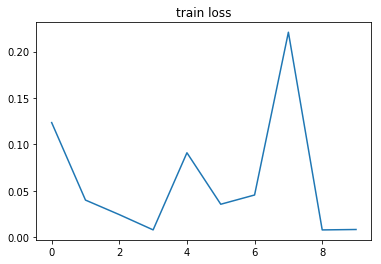

In [10]:
plt.figure()
plt.title('train loss')
plt.plot(train_loss_lst)

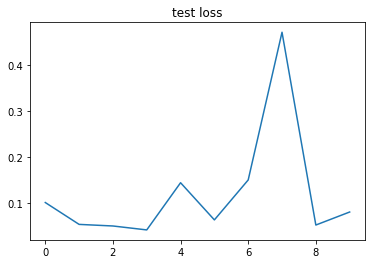

In [11]:
plt.figure()
plt.title('test loss')
plt.plot(test_loss_lst)

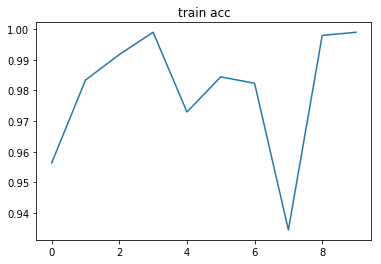

In [12]:
plt.figure()
plt.title('train acc')
plt.plot(train_acc_lst)

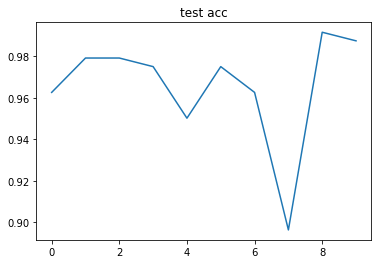

In [13]:
plt.figure()
plt.title('test acc')
plt.plot(test_acc_lst)